### Importing dependencies

In [ ]:
import os
from google.colab import drive

from tqdm import notebook as tqdm
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms

import torchvision.models as models

import sys
import math

## Loading and Pre Processing Data

Resizing the images (so they each have the same amount of pixels, not to overfit to larger images) and converting them to Tensor, so they can be used in the model.

Import the data from Google Drive as we assume that this is running on Google Colab.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
means = [0.43766510486602783, 0.49804747104644775, 0.3756938874721527]
stds = [0.16779577732086182, 0.1552586406469345, 0.1632111817598343]
transform_train = Compose([RandomHorizontalFlip(), RandomVerticalFlip(), Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_val = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_test = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])


train_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/train",transform=transform_train)
val_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/val",transform=transform_val)
test_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/test",transform=transform_test)
diffBg_dataset = ImageFolder(root="/content/drive/MyDrive/diffBg",transform=transform_test)

### Use a GPU if available

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

## Defining the DenseNet Model Architecture

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4 * growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(nChannels)
        self.conv = nn.Conv2d(nChannels, nOutChannels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out

class DenseNet(nn.Module):
    def __init__(self, growthRate=12, depth=40, reduction=0.5, num_classes=4):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth - 4) // 3
        nChannels = 2 * growthRate

        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1, bias=False)
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks)
        nChannels += nDenseBlocks * growthRate
        nOutChannels = int(nChannels * reduction)
        self.trans1 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks)
        nChannels += nDenseBlocks * growthRate
        nOutChannels = int(nChannels * reduction)
        self.trans2 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks)
        nChannels += nDenseBlocks * growthRate

        self.bn = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, num_classes)

    def _make_dense(self, nChannels, growthRate, nDenseBlocks):
        layers = []
        for i in range(int(nDenseBlocks)):
            layers.append(Bottleneck(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=1)



## Perform a sanity check for the correctness of the model

In [ ]:
net = DenseNet(growthRate=12, depth=30, reduction=0.5, num_classes=4)

net = net.to(device)
data = torch.randn(5,3,64,64)
data = data.to(device)
out = net.forward(data)
assert(out.detach().cpu().numpy().shape == (5,4))
print("Forward pass successful, shape matches")

for layer in net.children():
  print(layer)
  print(sum(p.numel() for p in layer.parameters()))

Forward pass successful, shape matches
Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
648
Sequential(
  (0): Bottleneck(
    (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (1): Bottleneck(
    (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (2): Bottleneck(
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Con

### Move data and the model to the GPU

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=16)
diffBg_dl = DataLoader(diffBg_dataset, batch_size=16)

!nvidia-smi

Mon Apr 22 22:17:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              26W /  70W |    415MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining a Loss Function and Optimizer

In [ ]:
# hyperparameters
INITIAL_LR = 0.001 # initial learning rate
MOMENTUM = 0.9 # momentum for optimizer

REG = 1e-3 # L2 regularization strength

criterion = nn.CrossEntropyLoss() # loss function

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay = REG)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY_EPOCHS = 10
DECAY = 1

## Train the model

In [ ]:
print("Training:")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(0, EPOCHS):
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    net.train() # switch to train mode

    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0

    train_loss = 0

    # 1 epoch training
    for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(train_dl), "training..."):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = net.forward(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # count the number of correctly predicted samples in the current batch

        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        correct_examples += correct
        total_examples += len(targets)
        train_loss += loss

    avg_loss = train_loss / len(train_dl)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    history['train_loss'].append(avg_loss)
    history['train_acc'].append(avg_acc)

    net.eval()

    total_examples = 0
    correct_examples = 0

    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(val_dl), "validating..."):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            correct_examples += correct
            total_examples += len(targets)
            val_loss += loss

    avg_loss = val_loss / len(val_dl)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    history['val_loss'].append(avg_loss)
    history['val_acc'].append(avg_acc)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'denseNet.pth'))

    print('')

print("="*50)
print(f"Optimization finished: best validation accuracy is {best_val_acc:.4f}")

Training:
Epoch 0:


training...: 0it [00:00, ?it/s]

Training loss: 1.1034, Training accuracy: 0.7089


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3089, Validation accuracy: 0.7355
Saving ...

Epoch 1:


training...: 0it [00:00, ?it/s]

Training loss: 0.7430, Training accuracy: 0.8104


validating...: 0it [00:00, ?it/s]

Validation loss: 0.6718, Validation accuracy: 0.8090
Saving ...

Epoch 2:


training...: 0it [00:00, ?it/s]

Training loss: 0.5813, Training accuracy: 0.8189


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5328, Validation accuracy: 0.8066

Epoch 3:


training...: 0it [00:00, ?it/s]

Training loss: 0.5102, Training accuracy: 0.8196


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4713, Validation accuracy: 0.8114
Saving ...

Epoch 4:


training...: 0it [00:00, ?it/s]

Training loss: 0.4555, Training accuracy: 0.8233


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4417, Validation accuracy: 0.8173
Saving ...

Epoch 5:


training...: 0it [00:00, ?it/s]

Training loss: 0.4297, Training accuracy: 0.8206


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4159, Validation accuracy: 0.8197
Saving ...

Epoch 6:


training...: 0it [00:00, ?it/s]

Training loss: 0.4137, Training accuracy: 0.8260


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4117, Validation accuracy: 0.8221
Saving ...

Epoch 7:


training...: 0it [00:00, ?it/s]

Training loss: 0.3889, Training accuracy: 0.8297


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3776, Validation accuracy: 0.8280
Saving ...

Epoch 8:


training...: 0it [00:00, ?it/s]

Training loss: 0.3805, Training accuracy: 0.8443


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3761, Validation accuracy: 0.8422
Saving ...

Epoch 9:


training...: 0it [00:00, ?it/s]

Training loss: 0.3562, Training accuracy: 0.8578


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3422, Validation accuracy: 0.8671
Saving ...

Current learning rate has decayed to 0.001000
Epoch 10:


training...: 0it [00:00, ?it/s]

Training loss: 0.3460, Training accuracy: 0.8683


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3389, Validation accuracy: 0.8897
Saving ...

Epoch 11:


training...: 0it [00:00, ?it/s]

Training loss: 0.3469, Training accuracy: 0.8798


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3398, Validation accuracy: 0.8992
Saving ...

Epoch 12:


training...: 0it [00:00, ?it/s]

Training loss: 0.3273, Training accuracy: 0.8832


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3402, Validation accuracy: 0.8909

Epoch 13:


training...: 0it [00:00, ?it/s]

Training loss: 0.3192, Training accuracy: 0.8930


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3051, Validation accuracy: 0.8909

Epoch 14:


training...: 0it [00:00, ?it/s]

Training loss: 0.3031, Training accuracy: 0.8951


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2919, Validation accuracy: 0.9051
Saving ...

Epoch 15:


training...: 0it [00:00, ?it/s]

Training loss: 0.2980, Training accuracy: 0.9001


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2868, Validation accuracy: 0.8956

Epoch 16:


training...: 0it [00:00, ?it/s]

Training loss: 0.2724, Training accuracy: 0.9032


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2818, Validation accuracy: 0.9027

Epoch 17:


training...: 0it [00:00, ?it/s]

Training loss: 0.2687, Training accuracy: 0.9042


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3024, Validation accuracy: 0.9110
Saving ...

Epoch 18:


training...: 0it [00:00, ?it/s]

Training loss: 0.2677, Training accuracy: 0.9123


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2577, Validation accuracy: 0.9158
Saving ...

Epoch 19:


training...: 0it [00:00, ?it/s]

Training loss: 0.2886, Training accuracy: 0.9198


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2876, Validation accuracy: 0.9004

Current learning rate has decayed to 0.001000
Epoch 20:


training...: 0it [00:00, ?it/s]

Training loss: 0.2666, Training accuracy: 0.9218


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2487, Validation accuracy: 0.9158

Epoch 21:


training...: 0it [00:00, ?it/s]

Training loss: 0.2551, Training accuracy: 0.9123


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2707, Validation accuracy: 0.9146

Epoch 22:


training...: 0it [00:00, ?it/s]

Training loss: 0.2268, Training accuracy: 0.9215


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2638, Validation accuracy: 0.9098

Epoch 23:


training...: 0it [00:00, ?it/s]

Training loss: 0.2305, Training accuracy: 0.9238


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2305, Validation accuracy: 0.9205
Saving ...

Epoch 24:


training...: 0it [00:00, ?it/s]

Training loss: 0.2252, Training accuracy: 0.9262


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2356, Validation accuracy: 0.9181

Epoch 25:


training...: 0it [00:00, ?it/s]

Training loss: 0.2073, Training accuracy: 0.9289


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2413, Validation accuracy: 0.9193

Epoch 26:


training...: 0it [00:00, ?it/s]

Training loss: 0.2113, Training accuracy: 0.9309


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2216, Validation accuracy: 0.9312
Saving ...

Epoch 27:


training...: 0it [00:00, ?it/s]

Training loss: 0.1977, Training accuracy: 0.9330


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2424, Validation accuracy: 0.9087

Epoch 28:


training...: 0it [00:00, ?it/s]

Training loss: 0.2134, Training accuracy: 0.9221


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2172, Validation accuracy: 0.9348
Saving ...

Epoch 29:


training...: 0it [00:00, ?it/s]

Training loss: 0.2043, Training accuracy: 0.9404


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2438, Validation accuracy: 0.9051

Optimization finished: best validation accuracy is 0.9348


### Show the plots of the training and validation losses

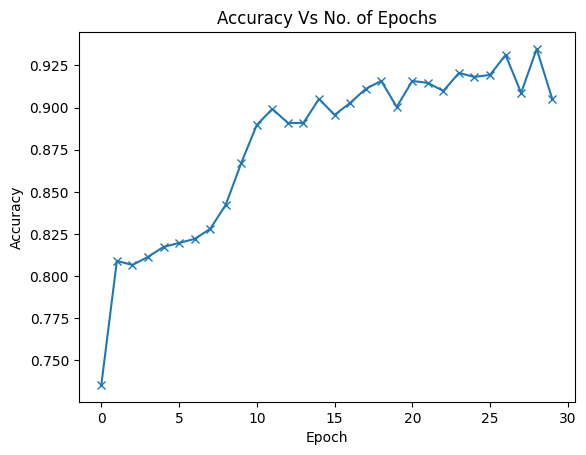

In [ ]:
def plot_accuracies(history):
  accuracies = [x.cpu().item() for x in history['val_acc']]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy Vs No. of Epochs")

plot_accuracies(history)

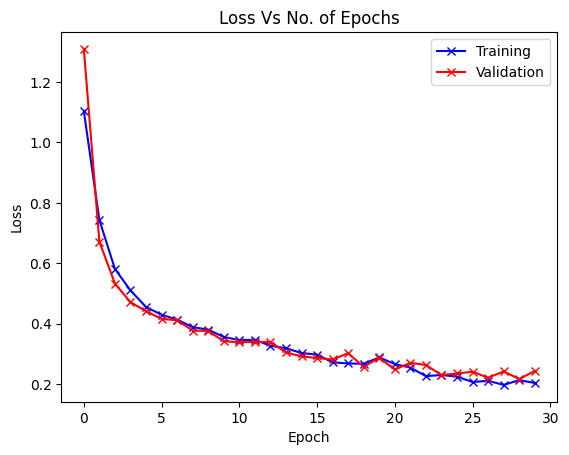

In [ ]:
def plot_losses(history):
  train_losses = [x.cpu().item() for x in history['train_loss']]
  val_losses = [x.cpu().item() for x in history['val_loss']]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training','Validation'])
  plt.title("Loss Vs No. of Epochs")
plot_losses(history)

### Evaluate the model with the test set

evaluating...:   0%|          | 0/27 [00:00<?, ?it/s]

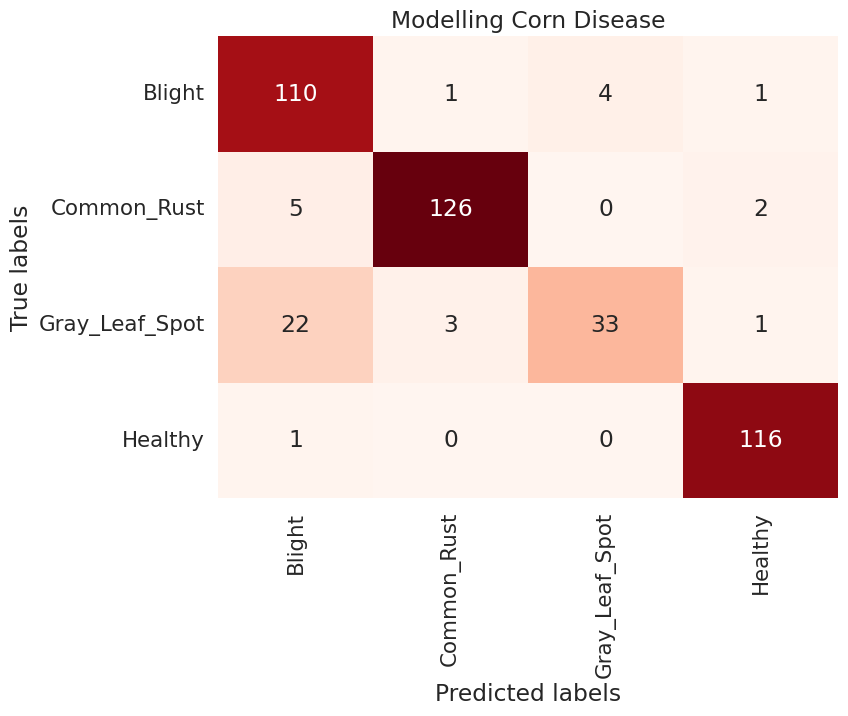

In [ ]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(test_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Modelling Corn Disease')
plt.show()

## Additional testing on images with different backgrounds

evaluating...:   0%|          | 0/17 [00:00<?, ?it/s]

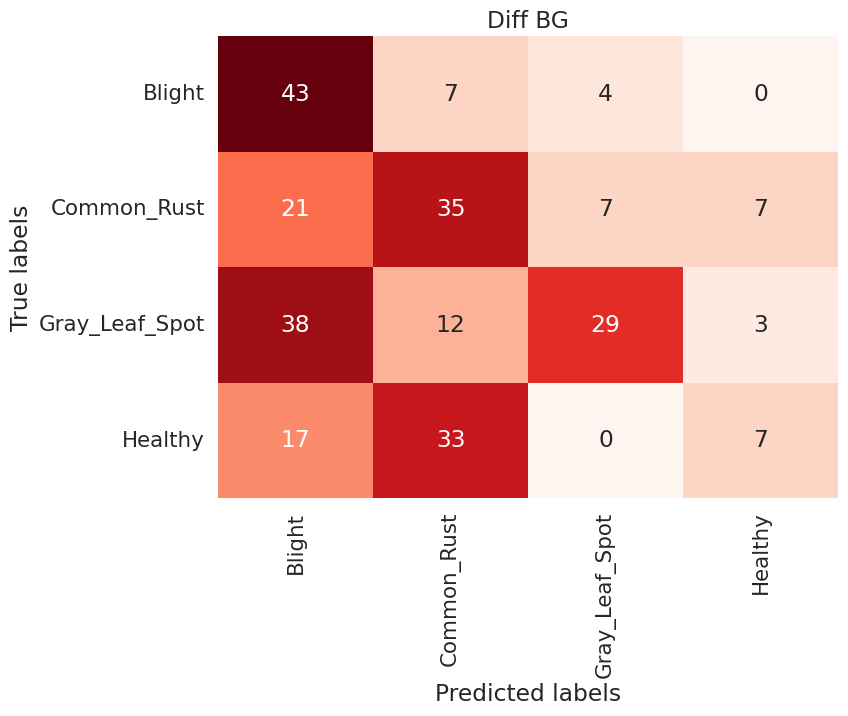

In [ ]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(diffBg_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Diff BG')
plt.show()